# Spam Detection - Classification 

This notebook walks through the step-by-step implementation for classification of spam emails.  

**Pipeline:**
1. Setup and Imports
2. Loading the dataset
3. Quick and easy data checks
4. Data tidying
5. Regex cleaning and numeric features
6. Building features
7. Clustering 
8. Results: cluster size, spam rate, top terms per cluster group
9. Save artefacts

# 1) Setup and Imports

In [1]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from scipy.sparse import hstack, csr_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS  ## WordCloud throws error without this


# 2) Loading the dataset

In [2]:
file_path = "emails.csv" 
df = pd.read_csv(file_path)

# 3) Quick and easy data checks

In [3]:
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nNulls per column:\n", df.isna().sum())
print("\nDtypes:\n", df.dtypes)
duplicate = df.duplicated(subset=["text"]).sum()
print(f"\nNumber of rows with duplicates: {duplicate}")
print("\n ")

print("\nClass balance (0=ham, 1=spam):")
print(df["spam"].value_counts())
print("Spam rate:", round(df["spam"].mean(), 3))


Shape: (5728, 2)

Columns: ['text', 'spam']

Nulls per column:
 text    0
spam    0
dtype: int64

Dtypes:
 text    object
spam     int64
dtype: object

Number of rows with duplicates: 33

 

Class balance (0=ham, 1=spam):
spam
0    4360
1    1368
Name: count, dtype: int64
Spam rate: 0.239


# 4) Data Cleaning and Feature

In [4]:
before = len(df)
df = df.drop_duplicates(subset=["text"]).reset_index(drop=True)

df["text"] = df["text"].astype(str).str.replace(r"\s+", " ", regex=True).str.strip()
print(f"Dropped {before - len(df)} duplicates. New total:", len(df))





Dropped 33 duplicates. New total: 5695


# 5) Futher cleaning and numeric features

In [5]:
URL_PATTERN = re.compile(r"http[s]?://\S+|www\.\S+") 
EMAIL_PATTERN = re.compile(r"\b[\w\.-]+@[\w\.-]+\.\w+\b") 
PHONE_PATTERN = re.compile(r'\b\d{3}-\d{3}-\d{4}\b') 
MONEY_PATTERN = re.compile(r'\$+\s*\d[\d\s,]*(?:[.]\d+)?') 


def clean_text(s: str) -> str:
    s = str(s).lower()
    s = re.sub(r"^subject:\s*", "", s) #remove "subject:" at the start of the text
    s = re.sub(r'\s*([^\w\s])\s*', r'\1', s) #remove the extra one space around punctuation.
    s = URL_PATTERN.sub(" URL ", s) #replace any links with the literal word URL 
    s = PHONE_PATTERN.sub(" PHONENUMBER ", s) #replace phone numbers with PHONENUMBER
    s = EMAIL_PATTERN.sub(" EMAIL ", s) #replace emails with EMAIL 
    s = MONEY_PATTERN.sub(" MONEY ", s) #replace numeric money into MONEY 
    s = re.sub(r'@\w+', '', s) #delete any mentions
    s = re.sub(r"[^a-zA-Z0-9\s]", " ", s) #remove special characters
    s = re.sub(r'\s+', ' ', s).strip()  # fix spaces and trim the end
    return s  

def count_special_chars(text):
    return len(re.findall(r'[!$%&*@#_?]', str(text))) 


df["text_clean"] = df["text"].apply(clean_text)
df = df.drop_duplicates(subset=["text_clean"]).reset_index(drop=True)



# 6) Outliar Removal and Feature Engineering

In [6]:
df["char_len"] = df["text_clean"].str.len()
df["word_len"] = df["text_clean"].str.split().str.len()
df["special_char_count"] = df["text"].apply(count_special_chars)
df["has_url"]  = df["text_clean"].str.contains(r"\bURL\b").astype(int)

print("Rows after cleaning:", len(df))

X = df[["text_clean", "char_len", "word_len","special_char_count", "has_url"]]
y = df["spam"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
q1 = X_train["char_len"].quantile(0.25)
q3 = X_train["char_len"].quantile(0.75)
iqr = q3 - q1
upper = q3 + 1.5 * iqr

X_train = X_train[X_train["char_len"] <= upper]
y_train = y_train.loc[X_train.index]


Rows after cleaning: 5492


# 7) Data Visualisation before deployment

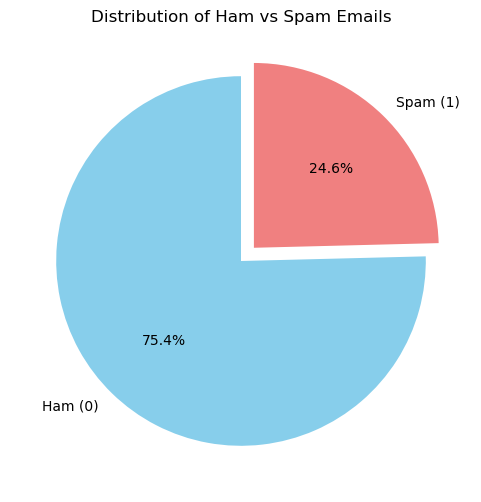

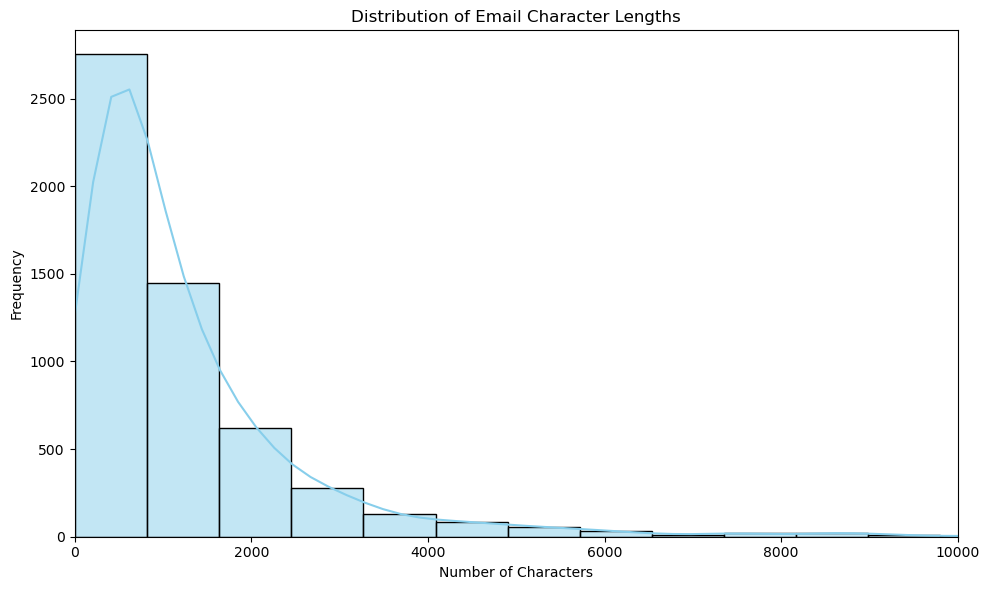

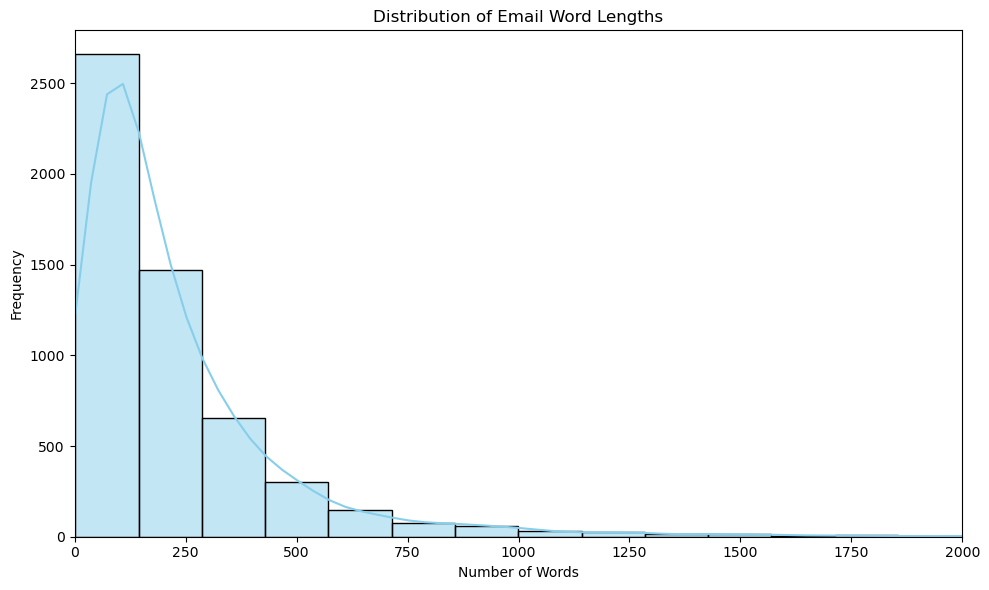

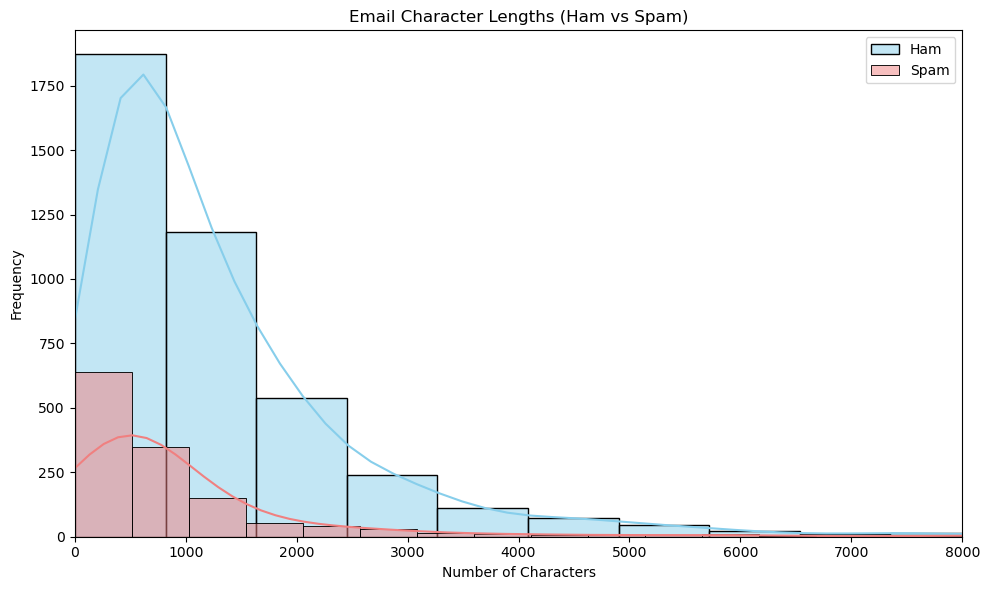

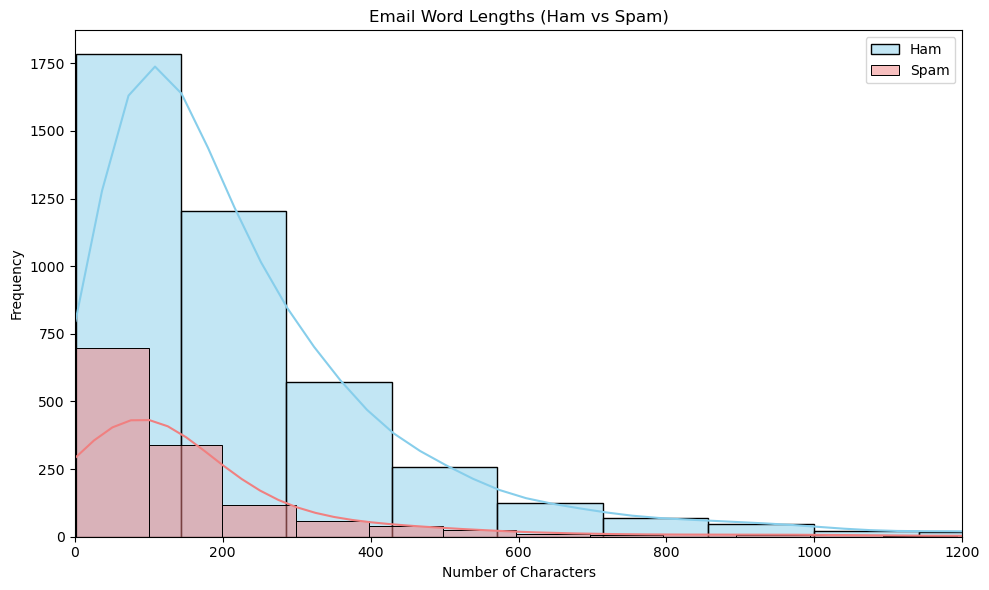

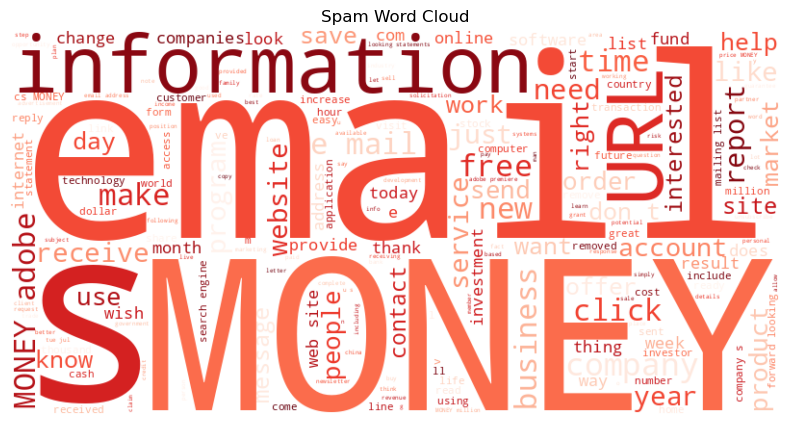

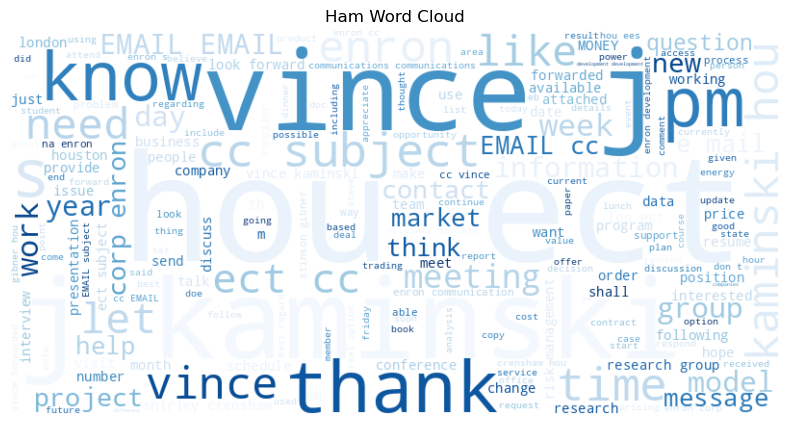

In [7]:

counts = df["spam"].value_counts()
labels = ['Ham (0)', 'Spam (1)']
colors = ['skyblue', 'lightcoral']

plt.figure(figsize=(6,6))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors, explode=(0, 0.1))
plt.title("Distribution of Ham vs Spam Emails")
plt.savefig("PieChart.png")
plt.tight_layout
plt.show()
plt.close()

plt.figure(figsize=(10,6))
sns.histplot(df["char_len"], bins=50, kde=True, color=colors[0])
plt.title("Distribution of Email Character Lengths")
plt.xlabel("Number of Characters")
plt.ylabel("Frequency")
plt.xlim(0, 10000) 
plt.tight_layout()
plt.savefig("CHaracterLengthHistogram.png") 
plt.show()
plt.close()


plt.figure(figsize=(10,6))
sns.histplot(df["word_len"], bins=50, kde=True, color=colors[0])
plt.title("Distribution of Email Word Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.xlim(0, 2000)
plt.tight_layout()
plt.savefig("WordLengthDistogram.png") 
plt.show() 
plt.close()



plt.figure(figsize=(10,6))
sns.histplot(df[df["spam"]==0]["char_len"], bins=50, color="skyblue", label="Ham", kde=True)
sns.histplot(df[df["spam"]==1]["char_len"], bins=50, color="lightcoral", label="Spam", kde=True)
plt.title("Email Character Lengths (Ham vs Spam)")
plt.xlabel("Number of Characters")
plt.ylabel("Frequency")
plt.xlim(0, 8000)
plt.legend()
plt.tight_layout()
plt.savefig("CharacterLength_Ham_vs_Spam.png")
plt.show()
plt.close()

plt.figure(figsize=(10,6))
sns.histplot(df[df["spam"]==0]["word_len"], bins=50, color="skyblue", label="Ham", kde=True)
sns.histplot(df[df["spam"]==1]["word_len"], bins=50, color="lightcoral", label="Spam", kde=True)
plt.title("Email Word Lengths (Ham vs Spam)")
plt.xlabel("Number of Characters")
plt.ylabel("Frequency")
plt.xlim(0, 1200)
plt.legend()
plt.tight_layout()
plt.savefig("WordLength_Ham_vs_Spam.png")
plt.show()
plt.close()

# Combine all spam emails into one big string
spam_text = " ".join(df[df["spam"] == 1]["text_clean"].astype(str))

# Combine all ham emails into one big string
ham_text = " ".join(df[df["spam"] == 0]["text_clean"].astype(str))

# Make a word cloud for spam
spam_wc = WordCloud(
    width=800, 
    height=400, 
    background_color="white", 
    colormap="Reds", 
    stopwords=ENGLISH_STOP_WORDS  # remove common words like 'the', 'and'
).generate(spam_text)

# Make a word cloud for ham
ham_wc = WordCloud(
    width=800, 
    height=400, 
    background_color="white", 
    colormap="Blues",
    stopwords=ENGLISH_STOP_WORDS
).generate(ham_text)

# Show spam word cloud
plt.figure(figsize=(10,5))
plt.imshow(spam_wc, interpolation='bilinear')  # show the image
plt.axis("off")  # remove axes
plt.title("Spam Word Cloud")
plt.show()

# Show ham word cloud
plt.figure(figsize=(10,5))
plt.imshow(ham_wc, interpolation='bilinear')
plt.axis("off")
plt.title("Ham Word Cloud")
plt.show()


# 7) Model Training 

In [8]:

vectorizer = TfidfVectorizer(ngram_range=(1,1), max_features=5000,  stop_words="english")
X_train_tfidf = vectorizer.fit_transform(X_train["text_clean"])
X_test_tfidf  = vectorizer.transform(X_test["text_clean"])



numeric_cols = ["char_len", "word_len", "special_char_count", "has_url"]
numeric_train = X_train[numeric_cols]
numeric_test  = X_test[numeric_cols]

scaler = StandardScaler()
numeric_train_scaled = scaler.fit_transform(numeric_train)
numeric_test_scaled  = scaler.transform(numeric_test)

# Combine TF-IDF and numeric arrays
X_train_final = hstack([X_train_tfidf, numeric_train_scaled])
X_test_final  = hstack([X_test_tfidf, numeric_test_scaled])

logreg = LogisticRegression(C=0.3, class_weight={0:1, 1:4}, max_iter=1000, random_state=42)
logreg.fit(X_train_final, y_train)


LogisticRegression(C=0.3, class_weight={0: 1, 1: 4}, max_iter=1000,
                   random_state=42)

# 8) Logistic Regression Result

In [9]:

y_pred = logreg.predict(X_test_final)
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec  = recall_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)
cm   = confusion_matrix(y_test, y_pred)

print("\n=== Logistic Regression Results ===")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1 Score : {f1:.4f}")
print("Confusion Matrix:\n", cm)



=== Logistic Regression Results ===
Accuracy : 0.9600
Precision: 0.9007
Recall   : 0.9407
F1 Score : 0.9203
Confusion Matrix:
 [[801  28]
 [ 16 254]]


# 9) KNN Implementation and evaluation

In [79]:

### KNN IMPLEMENTATION ###########
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_final, y_train)

##KNN EVALUATION ###########

y_pred_knn = knn.predict(X_test_final)
acc_knn  = accuracy_score(y_test, y_pred_knn)
prec_knn = precision_score(y_test, y_pred_knn)
rec_knn  = recall_score(y_test, y_pred_knn)
f1_knn   = f1_score(y_test, y_pred_knn)
cm_knn   = confusion_matrix(y_test, y_pred_knn)

print("\n=== KNN Results ===")
print(f"Accuracy : {acc_knn:.4f}")
print(f"Precision: {prec_knn:.4f}")
print(f"Recall   : {rec_knn:.4f}")
print(f"F1 Score : {f1_knn:.4f}")
print("Confusion Matrix")
print(cm_knn)




=== KNN Results ===
Accuracy : 0.9490
Precision: 0.9496
Recall   : 0.8370
F1 Score : 0.8898
Confusion Matrix
[[817  12]
 [ 44 226]]


# 10) Data Visualisation after deployment


Logistic Regression Confusion Matrix


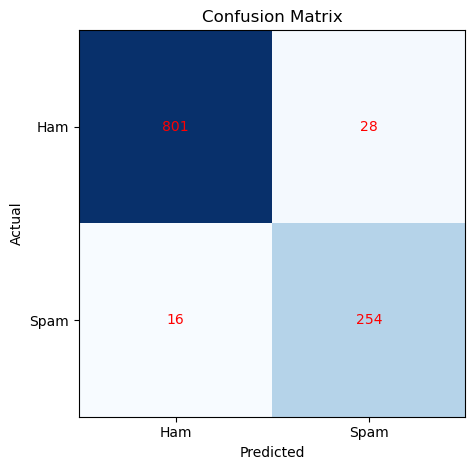

KNN Confusion Matrix


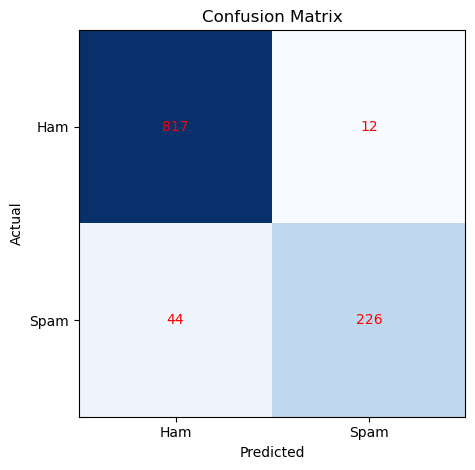

In [74]:
print("Logistic Regression Confusion Matrix")

plt.figure()
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xticks([0,1], ["Ham","Spam"])
plt.yticks([0,1], ["Ham","Spam"])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i,j], ha="center", va="center", color="red")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.tight_layout()
plt.savefig("confusion_matrix LOGISTICREGRESSION.png")
plt.show()
plt.close()


print("KNN Confusion Matrix")

plt.figure()
plt.imshow(cm_knn, cmap="Blues")
plt.title("Confusion Matrix")
plt.xticks([0,1], ["Ham","Spam"])
plt.yticks([0,1], ["Ham","Spam"])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm_knn[i,j], ha="center", va="center", color="red")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.tight_layout()
plt.savefig("confusion_matrix KNN.png")
plt.show()
plt.close()


